https://data.cityofnewyork.us/Environment/New-York-City-s-Flood-Vulnerability-Index/mrjc-v9pm/about_data

This maps two charts, one of which is all of the subway train rides and the second is a NYC Flood Vulnerability index. It aims to see the impact of potential floods on NYC subways. 

However, it only shows the subway stations as vulnerable and not the infrastructure between stops or the actual lines. 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt

from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.cm as cm

import matplotlib.colors as mcolors

import geopandas as gpd
import folium
import matplotlib.pyplot as plt

import branca

import pandas as pd
from io import StringIO
import requests

from folium import FeatureGroup


Get Vulnerability Index Data

In [2]:
# Read the shapefile
df = pd.read_csv("New_York_City_s_Flood_Vulnerability_Index_20240930.csv")
# Read the shapefile
gdf = gpd.read_file("/Users/bricenfisher/Downloads/New York City's Flood Vulnerability Index_20240930/geo_export_d5f0fd6a-fb11-4302-8722-c77598d0deab.shp")


Get Transit User Data

In [3]:
def establish_nys_session():
    session = requests.Session()
    # Add headers or authentication if needed
    return session

url = """https://data.ny.gov/resource/wujg-7c2s.csv?$query=
SELECT 
    station_complex,
    Georeference,
    round(SUM(ridership),0) AS total_ridership
WHERE 
    transit_timestamp >= '2023-09-31T00:00:00' 
    AND 
    transit_timestamp <= '2024-01-01T00:00:00'
GROUP BY 
    station_complex, Georeference
ORDER BY 
    station_complex
"""

session = establish_nys_session()
response = session.get(url)


# Convert the CSV response to a DataFrame
data = StringIO(response.text)

df = pd.read_csv(data, header=0)

In [4]:
df_polygons = gdf
df_points = df

Clean DataFrames

In [5]:
df_polygons['ss_cur'] = df_polygons['ss_cur'].fillna(0)
df_polygons['ss_50s'] = df_polygons['ss_50s'].fillna(0)
df_polygons['ss_80s'] = df_polygons['ss_80s'].fillna(0)
df_polygons['tid_20s'] = df_polygons['tid_20s'].fillna(0)
df_polygons['tid_50s'] = df_polygons['tid_50s'].fillna(0)
df_polygons['tid_80s'] = df_polygons['tid_80s'].fillna(0)

df_polygons['ss_cur'] = pd.to_numeric(df_polygons['ss_cur'], errors='coerce')
df_polygons['ss_50s'] = pd.to_numeric(df_polygons['ss_50s'], errors='coerce')
df_polygons['ss_80s'] = pd.to_numeric(df_polygons['ss_80s'], errors='coerce')
df_polygons['tid_20s'] = pd.to_numeric(df_polygons['tid_20s'], errors='coerce')
df_polygons['tid_50s'] = pd.to_numeric(df_polygons['tid_50s'], errors='coerce')
df_polygons['tid_80s'] = pd.to_numeric(df_polygons['tid_80s'], errors='coerce')

df_points.columns = df_points.columns.str.strip()
df_polygons.columns = df_polygons.columns.str.strip()

gdf1 = gpd.GeoDataFrame(df_points, geometry=gpd.GeoSeries.from_wkt(df_points['Georeference']))
gdf2 = df_polygons

KeyError: 'Georeference'

gdf1 is the subway stations
gdf2 is the polygons of the vulnerable areas

Merge DataFrames

In [ ]:
gdf1['Georeference'] = gdf1['Georeference'].apply(wkt.loads)  # Convert the Georeference points from WKT format
gdf1 = gpd.GeoDataFrame(gdf1, geometry='Georeference', crs="EPSG:4326")  # Assuming WGS84 for points
gdf2 = gdf2.set_crs("EPSG:4326", allow_override=True)

In [ ]:
gdf1.info()
gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   station_complex  483 non-null    object  
 1   Georeference     483 non-null    geometry
 2   total_ridership  483 non-null    int64   
 3   geometry         483 non-null    geometry
dtypes: geometry(2), int64(1), object(1)
memory usage: 15.2+ KB
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2209 entries, 0 to 2208
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     2209 non-null   object  
 1   fshri     2207 non-null   object  
 2   ss_cur    2209 non-null   int64   
 3   ss_50s    2209 non-null   int64   
 4   ss_80s    2209 non-null   int64   
 5   tid_20s   2209 non-null   int64   
 6   tid_50s   2209 non-null   int64   
 7   tid_80s   2209 non-null   int64   
 8   geometry  2209 non-null

In [ ]:
def get_pip (gdf, regions):
    r_list = list(regions.geoid)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for r in r_list:
        #get geometry for specific region
        pol = (regions.loc[regions.geoid==r])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the region geoid as the value
        pip_data['region']= r
        #append region data to empty dataframe
        df = pd.concat([df,pip_data])
    #checking there are no more than one region assigned to an event    
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    
    df.reset_index(inplace=True, drop=True)
    df = df.drop(columns='geometry')
    return df

eq_df = get_pip(gdf1, gdf2)

/var/folders/wm/w3d80c152lq65mt41y20p1200000gn/T/ipykernel_59849/681669060.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pip_data])


Original dataframe count= 483 
New dataframe count= 465


In [ ]:
eq_df

station_complex                Georeference  total_ridership  \
0                Avenue U (Q)  POINT (-73.95593 40.59930)           2757.0   
1                Avenue H (Q)  POINT (-73.96164 40.62927)            920.0   
2                Avenue J (Q)  POINT (-73.96080 40.62504)           1899.0   
3                Elder Av (6)  POINT (-73.87916 40.82858)           2042.0   
4       82 St-Jackson Hts (7)  POINT (-73.88370 40.74766)           3301.0   
..                        ...                         ...              ...   
460                7 Av (F,G)  POINT (-73.98031 40.66627)           4697.0   
461            8 St-NYU (R,W)  POINT (-73.99263 40.73033)           7463.0   
462              Astor Pl (6)  POINT (-73.99107 40.73005)           7718.0   
463  Canal St (J,N,Q,R,W,Z,6)  POINT (-74.00178 40.71953)             70.0   
464                191 St (1)  POINT (-73.92941 40.85522)           2790.0   

          region  
0    36047058000  
1    36047053200  
2    36047053200  
3    36005005400  
4    36081028300  
..           ...  
460  36047015100  
461  36061005700  
462  36061005700  
463  36061004700  
464  36061027700  

[465 rows x 4 columns]

In [ ]:
summed_ridership = eq_df.groupby('region')['total_ridership'].sum()
summed_ridership = summed_ridership.reset_index()
summed_ridership.columns = ['geoid', 'total_ridership']
summed_ridership

geoid  total_ridership
0    36005002300           2238.0
1    36005002702            601.0
2    36005003100            202.0
3    36005003900           1741.0
4    36005004800           1715.0
..           ...              ...
374  36081099801            438.0
375  36081100803           1402.0
376  36081107201             62.0
377  36085000300           1940.0
378  36085002100            203.0

[379 rows x 2 columns]

In [ ]:
gdf2

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...  
...                                                 ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...  

[2209 rows x 9 columns]

In [ ]:
print(gdf2['geoid'].nunique())


2209


In [ ]:
summed_ridership

geoid  total_ridership
0    36005002300           2238.0
1    36005002702            601.0
2    36005003100            202.0
3    36005003900           1741.0
4    36005004800           1715.0
..           ...              ...
374  36081099801            438.0
375  36081100803           1402.0
376  36081107201             62.0
377  36085000300           1940.0
378  36085002100            203.0

[379 rows x 2 columns]

In [ ]:
gdf_with_ridership = gdf2.merge(summed_ridership, on = "geoid", how = 'left')

In [ ]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              NaN  
...                                                 ...              ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN  

[2209 rows x 10 columns]

In [ ]:
eq_df
eq_df_merge = eq_df[['station_complex','region']]

In [ ]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36005036300     5       0       0       0        0        0        0   
4     36081035700     5       1       1       1        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2204  36061004700     1       3       3       3        0        0        0   
2205  36061025500     1       0       0       0        0        0        0   
2206  36061027700     1       0       0       0        0        0        0   
2207  36005009302   NaN       0       0       0        0        0        0   
2208  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN  
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0  
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0  
3     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN  
4     POLYGON ((-73.87639 40.76900, -73.87602 40.770...              NaN  
...                                                 ...              ...  
2204  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0  
2205  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN  
2206  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0  
2207  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN  
2208  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN  

[2209 rows x 10 columns]

In [ ]:
gdf_with_ridership = pd.merge(gdf_with_ridership, eq_df_merge, left_on='geoid', right_on='region', how='left')

In [ ]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36047053200     5       0       0       0        0        0        0   
4     36005036300     5       0       0       0        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2290  36061004700     1       3       3       3        0        0        0   
2291  36061025500     1       0       0       0        0        0        0   
2292  36061027700     1       0       0       0        0        0        0   
2293  36005009302   NaN       0       0       0        0        0        0   
2294  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              NaN   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
3     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
4     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              NaN   
...                                                 ...              ...   
2290  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0   
2291  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              NaN   
2292  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0   
2293  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              NaN   
2294  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              NaN   

               station_complex       region  
0                          NaN          NaN  
1                 Avenue U (Q)  36047058000  
2                 Avenue H (Q)  36047053200  
3                 Avenue J (Q)  36047053200  
4                          NaN          NaN  
...                        ...          ...  
2290  Canal St (J,N,Q,R,W,Z,6)  36061004700  
2291                       NaN          NaN  
2292                191 St (1)  36061027700  
2293                       NaN          NaN  
2294                       NaN          NaN  

[2295 rows x 12 columns]

In [ ]:
gdf_with_ridership
gdf_with_ridership['total_ridership'] = gdf_with_ridership['total_ridership'].fillna(0)
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36047053200     5       0       0       0        0        0        0   
4     36005036300     5       0       0       0        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2290  36061004700     1       3       3       3        0        0        0   
2291  36061025500     1       0       0       0        0        0        0   
2292  36061027700     1       0       0       0        0        0        0   
2293  36005009302   NaN       0       0       0        0        0        0   
2294  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
3     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
4     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
...                                                 ...              ...   
2290  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0   
2291  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2292  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0   
2293  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2294  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

               station_complex       region  
0                          NaN          NaN  
1                 Avenue U (Q)  36047058000  
2                 Avenue H (Q)  36047053200  
3                 Avenue J (Q)  36047053200  
4                          NaN          NaN  
...                        ...          ...  
2290  Canal St (J,N,Q,R,W,Z,6)  36061004700  
2291                       NaN          NaN  
2292                191 St (1)  36061027700  
2293                       NaN          NaN  
2294                       NaN          NaN  

[2295 rows x 12 columns]

Some Prelim Data Analysis and Plots

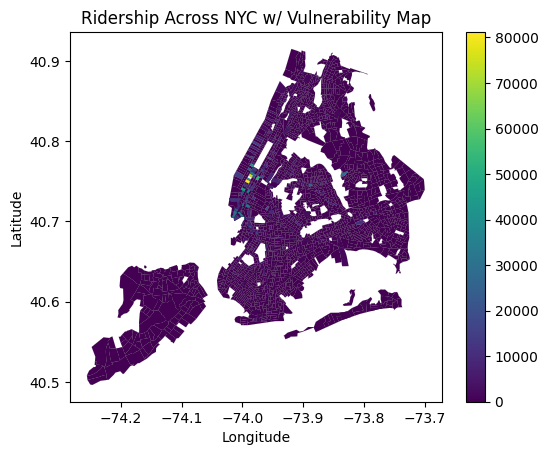

In [ ]:
gdf_with_ridership.plot(column='total_ridership', legend=True, edgecolor='black',linewidth= 0.05)

plt.title('Ridership Across NYC w/ Vulnerability Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

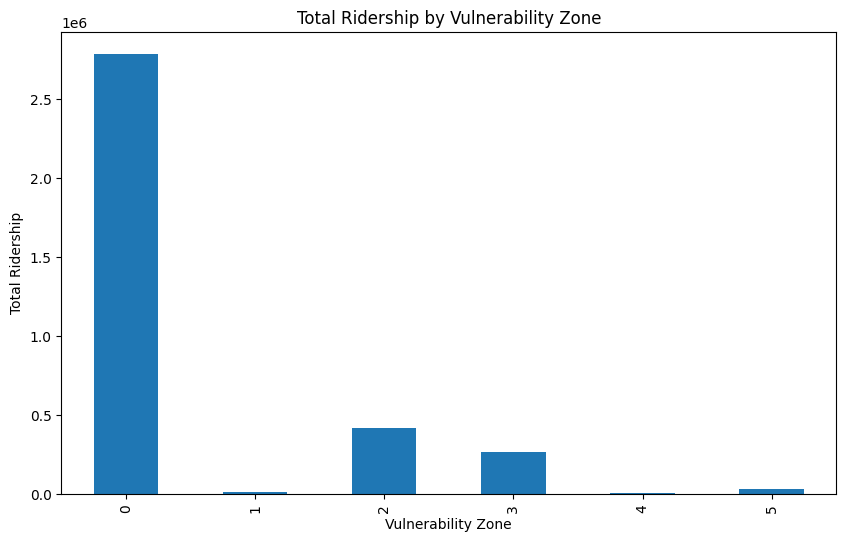

In [ ]:
gdf_with_ridership.groupby("ss_cur")["total_ridership"].sum().plot(kind='bar', figsize=(10,6))
# Add labels and title
plt.xlabel("Vulnerability Zone")
plt.ylabel("Total Ridership")
plt.title("Total Ridership by Vulnerability Zone")

# Show the plot
plt.show()

There are 14 stations in zone 5 vulnerability

In [ ]:
print(gdf_with_ridership.groupby("ss_cur")["total_ridership"].count())


ss_cur
0    1906
1      73
2      85
3      83
4      73
5      75
Name: total_ridership, dtype: int64


In [ ]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36047053200     5       0       0       0        0        0        0   
4     36005036300     5       0       0       0        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2290  36061004700     1       3       3       3        0        0        0   
2291  36061025500     1       0       0       0        0        0        0   
2292  36061027700     1       0       0       0        0        0        0   
2293  36005009302   NaN       0       0       0        0        0        0   
2294  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
3     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
4     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
...                                                 ...              ...   
2290  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0   
2291  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2292  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0   
2293  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2294  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

               station_complex       region  
0                          NaN          NaN  
1                 Avenue U (Q)  36047058000  
2                 Avenue H (Q)  36047053200  
3                 Avenue J (Q)  36047053200  
4                          NaN          NaN  
...                        ...          ...  
2290  Canal St (J,N,Q,R,W,Z,6)  36061004700  
2291                       NaN          NaN  
2292                191 St (1)  36061027700  
2293                       NaN          NaN  
2294                       NaN          NaN  

[2295 rows x 12 columns]

In [ ]:
Zone_0_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 0]
Zone_1_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 1]
Zone_2_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 2]
Zone_3_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 3]
Zone_4_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 4]
Zone_5_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 5]

geo_json_data_Zone_0_ss_cur = Zone_0_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_1_ss_cur = Zone_1_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_2_ss_cur = Zone_2_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_3_ss_cur = Zone_3_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_4_ss_cur = Zone_4_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_5_ss_cur = Zone_5_ss_cur.to_crs(epsg=4326).to_json()

m = folium.Map(location=[40.643315421898, -73.95109946110213], zoom_start=10.5, tiles = 'Cartodb Positron')

# Create three different FeatureGroups for different layers
group0 = FeatureGroup(name='Zone 0', show=True)  # Show this group by default
group1 = FeatureGroup(name='Zone 1', show=True)  # Initially hidden
group2 = FeatureGroup(name='Zone 2', show=True)  # Initially hidden
group3 = FeatureGroup(name='Zone 3', show=True)  # Initially hidden
group4 = FeatureGroup(name='Zone 4', show=True)  # Initially hidden
group5 = FeatureGroup(name='Zone 5', show=True)  # Initially hidden

# Add some markers to each layer
group0.add_child(folium.GeoJson(geo_json_data_Zone_0_ss_cur, name="Polygons"))
group1.add_child(folium.GeoJson(geo_json_data_Zone_1_ss_cur, name="Polygons"))
group2.add_child(folium.GeoJson(geo_json_data_Zone_2_ss_cur, name="Polygons"))
group3.add_child(folium.GeoJson(geo_json_data_Zone_3_ss_cur, name="Polygons"))
group4.add_child(folium.GeoJson(geo_json_data_Zone_4_ss_cur, name="Polygons"))
group5.add_child(folium.GeoJson(geo_json_data_Zone_5_ss_cur, name="Polygons"))


# Add FeatureGroups to the map
m.add_child(group0)
m.add_child(group1)
m.add_child(group2)
m.add_child(group3)
m.add_child(group4)
m.add_child(group5)

# Add Layer Control to toggle between layers
folium.LayerControl(collapsed=False).add_to(m)  # Expanded by default

m

In [ ]:
gdf_with_ridership

geoid fshri  ss_cur  ss_50s  ss_80s  tid_20s  tid_50s  tid_80s  \
0     36081036300     5       0       0       0        0        0        0   
1     36047058000     5       0       0       2        0        0        0   
2     36047053200     5       0       0       0        0        0        0   
3     36047053200     5       0       0       0        0        0        0   
4     36005036300     5       0       0       0        0        0        0   
...           ...   ...     ...     ...     ...      ...      ...      ...   
2290  36061004700     1       3       3       3        0        0        0   
2291  36061025500     1       0       0       0        0        0        0   
2292  36061027700     1       0       0       0        0        0        0   
2293  36005009302   NaN       0       0       0        0        0        0   
2294  36005028400   NaN       2       1       1        0        0        0   

                                               geometry  total_ridership  \
0     POLYGON ((-73.87135 40.76233, -73.86826 40.761...              0.0   
1     POLYGON ((-73.95776 40.60099, -73.95683 40.601...           2757.0   
2     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
3     POLYGON ((-73.96230 40.62996, -73.96137 40.630...           2819.0   
4     POLYGON ((-73.88545 40.84377, -73.88529 40.844...              0.0   
...                                                 ...              ...   
2290  POLYGON ((-74.00479 40.72362, -74.00458 40.724...             70.0   
2291  POLYGON ((-73.95416 40.84799, -73.95283 40.851...              0.0   
2292  POLYGON ((-73.93008 40.85431, -73.92964 40.854...           2790.0   
2293  POLYGON ((-73.90307 40.80988, -73.89917 40.812...              0.0   
2294  POLYGON ((-73.84494 40.84821, -73.84359 40.850...              0.0   

               station_complex       region  
0                          NaN          NaN  
1                 Avenue U (Q)  36047058000  
2                 Avenue H (Q)  36047053200  
3                 Avenue J (Q)  36047053200  
4                          NaN          NaN  
...                        ...          ...  
2290  Canal St (J,N,Q,R,W,Z,6)  36061004700  
2291                       NaN          NaN  
2292                191 St (1)  36061027700  
2293                       NaN          NaN  
2294                       NaN          NaN  

[2295 rows x 12 columns]

In [ ]:
Zone_0_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 0]
Zone_1_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 1]
Zone_2_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 2]
Zone_3_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 3]
Zone_4_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 4]
Zone_5_ss_cur = gdf_with_ridership[gdf_with_ridership['ss_cur'] == 5]

geo_json_data_Zone_0_ss_cur = Zone_0_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_1_ss_cur = Zone_1_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_2_ss_cur = Zone_2_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_3_ss_cur = Zone_3_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_4_ss_cur = Zone_4_ss_cur.to_crs(epsg=4326).to_json()
geo_json_data_Zone_5_ss_cur = Zone_5_ss_cur.to_crs(epsg=4326).to_json()

# Define a colormap based on the 'total_ridership' values
min_value = gdf_with_ridership['total_ridership'].min()
max_value = gdf_with_ridership['total_ridership'].max()

# Create a color map (e.g., Viridis colormap)
colors = ['#f7fcf0', '#e0f3db', '#ccece6', '#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#006d2c']
colormap = branca.colormap.StepColormap(colors, vmin=min_value, vmax=max_value, index=[min_value + (max_value - min_value) * i / (len(colors) - 1) for i in range(len(colors))])
colormap.caption = 'Total Ridership'  # Add a caption for the color legend

# Function to style the GeoJson based on the 'total_ridership' value
def style_function(feature):
    ridership_value = feature['properties']['total_ridership']
    return {
        'fillColor': colormap(ridership_value),
        'color': 'black',  # Polygon border color
        'weight': 1,  # Border thickness
        'fillOpacity': 0.7,  # Transparency of the fill color
    }

m = folium.Map(location=[40.643315421898, -73.95109946110213], zoom_start=10.5, tiles = 'Cartodb Positron')

# Create three different FeatureGroups for different layers
group0 = FeatureGroup(name='Zone 0', show=True)  # Show this group by default
group1 = FeatureGroup(name='Zone 1', show=True)  # Initially hidden
group2 = FeatureGroup(name='Zone 2', show=True)  # Initially hidden
group3 = FeatureGroup(name='Zone 3', show=True)  # Initially hidden
group4 = FeatureGroup(name='Zone 4', show=True)  # Initially hidden
group5 = FeatureGroup(name='Zone 5', show=True)  # Initially hidden

# Add some markers to each layer
group0.add_child(folium.GeoJson(geo_json_data_Zone_0_ss_cur, style_function=style_function,tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','geoid'], aliases=['Zone:', 'Ridership:','Location:'])))

group0.add_child(
    folium.GeoJson(
    geo_json_data_Zone_0_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group1.add_child(
    folium.GeoJson(
    geo_json_data_Zone_1_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group2.add_child(
    folium.GeoJson(
    geo_json_data_Zone_2_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group3.add_child(
    folium.GeoJson(
    geo_json_data_Zone_3_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group4.add_child(
    folium.GeoJson(
    geo_json_data_Zone_4_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)

group5.add_child(
    folium.GeoJson(
    geo_json_data_Zone_5_ss_cur, 
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['ss_cur', 'total_ridership','station_complex'], aliases=['Zone:', 'Ridership:','Location:'])
)
)


# Add FeatureGroups to the map
m.add_child(group0)
m.add_child(group1)
m.add_child(group2)
m.add_child(group3)
m.add_child(group4)
m.add_child(group5)

# Add Layer Control to toggle between layers
folium.LayerControl(collapsed=False).add_to(m)  # Expanded by default
colormap.add_to(m)

m